In this notebook, we will build our ML algorithim based on the bulk data we already have from the selected 5 compaines. 
- Develop different classifier models and compare performance
- Develop different linear models and look and compare performance
- Select the best classifier, and the best linear model
- Plot both models in a visulization tool to compare outcomes based on the test-data
- Build a daily trading strategy based on the outcome
- Save the model and test it with the API for new data testing

In [19]:
#load libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import seaborn as sns
import json as json
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

In [20]:
#load the data
data = pd.read_csv('Combined_data')

In [21]:
#We want to predict if today price will be more than yesterday
#or no so we need to add this to existing data first

data = data.sort_values(by=['Ticker', 'Date'])


In [22]:

# Apply the comparison within each group of ticker
data['Tomorrow_Close_Positive'] = data.groupby('Ticker')['Close'].transform(lambda x: x.shift(-1)>x)


In [23]:
#making sure that the calculations workerd!
data[data['Ticker']=='TSLA'][['Close','Tomorrow_Close_Positive']]

,Close,Tomorrow_Close_Positive
4956,19.28,False
4957,19.06,True
4958,19.45,False
4959,17.85,True
4960,18.33,False
...,...,...
6190,199.40,True
6191,199.73,True
6192,202.04,False
6193,201.88,True


**looking at the null values and deciding what to do with them**

In [24]:
data.isnull().sum()

Ticker                                                0
Unnamed: 1                                            0
Ticker.1                                              0
SimFinId_x                                            0
Date                                                  0
Open                                                  0
High                                                  0
Low                                                   0
Close                                                 0
Adj. Close                                            0
Volume                                                0
Dividend                                           6135
Shares Outstanding                                    0
Fiscal Year                                           0
Fiscal Period                                         0
SimFinId_y                                          189
Currency                                            189
Report Date                                     

In [25]:
threshold = len(data) - 200  # Columns must have more than (len(data) - 100) non-null values
data = data.dropna(axis=1, thresh=threshold)
data.isnull().sum()

Ticker                                               0
Unnamed: 1                                           0
Ticker.1                                             0
SimFinId_x                                           0
Date                                                 0
Open                                                 0
High                                                 0
Low                                                  0
Close                                                0
Adj. Close                                           0
Volume                                               0
Shares Outstanding                                   0
Fiscal Year                                          0
Fiscal Period                                        0
SimFinId_y                                         189
Currency                                           189
Report Date                                        189
Publish Date                                       189
Restated D

In [26]:
data.columns

Index(['Ticker', 'Unnamed: 1', 'Ticker.1', 'SimFinId_x', 'Date', 'Open',
       'High', 'Low', 'Close', 'Adj. Close', 'Volume', 'Shares Outstanding',
       'Fiscal Year', 'Fiscal Period', 'SimFinId_y', 'Currency', 'Report Date',
       'Publish Date', 'Restated Date', 'Shares (Basic)', 'Shares (Diluted)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities',
       'Share Capital & Additional Paid-In Capital', 'Retained Earnings',
       'Total Equity', 'Total Liabilities & Equity', 'week', 'First_day',
       'Last_day', 'SMA_7', 'V_SMA_7', 'SMA_14', 'V_SMA_14', 'EMA_7',
       'V_EMA_7', 'EMA_14', 'V_EMA_14', 'Tomorrow_Close_Positive'],
      dtype='object')

In [27]:
data = data.drop(columns=['Unnamed: 1', 'Ticker.1', 'SimFinId_x','SimFinId_y', 'Currency'])

In [28]:
data.fillna(0, inplace=True)


In [29]:
data.isnull().sum()

Ticker                                             0
Date                                               0
Open                                               0
High                                               0
Low                                                0
Close                                              0
Adj. Close                                         0
Volume                                             0
Shares Outstanding                                 0
Fiscal Year                                        0
Fiscal Period                                      0
Report Date                                        0
Publish Date                                       0
Restated Date                                      0
Shares (Basic)                                     0
Shares (Diluted)                                   0
Cash, Cash Equivalents & Short Term Investments    0
Accounts & Notes Receivable                        0
Total Current Assets                          

In [30]:
data.select_dtypes(include=['object'])

,Ticker,Date,Fiscal Period,Report Date,Publish Date,Restated Date
0,AAPL,2019-04-01,Q2,2019-03-31,2019-05-01,2019-05-01
1,AAPL,2019-04-02,Q2,2019-03-31,2019-05-01,2019-05-01
2,AAPL,2019-04-03,Q2,2019-03-31,2019-05-01,2019-05-01
3,AAPL,2019-04-04,Q2,2019-03-31,2019-05-01,2019-05-01
4,AAPL,2019-04-05,Q2,2019-03-31,2019-05-01,2019-05-01
...,...,...,...,...,...,...
6190,TSLA,2024-02-26,Q1,0,0,0
6191,TSLA,2024-02-27,Q1,0,0,0
6192,TSLA,2024-02-28,Q1,0,0,0
6193,TSLA,2024-02-29,Q1,0,0,0


In [31]:
data.columns

Index(['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj. Close',
       'Volume', 'Shares Outstanding', 'Fiscal Year', 'Fiscal Period',
       'Report Date', 'Publish Date', 'Restated Date', 'Shares (Basic)',
       'Shares (Diluted)', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities',
       'Share Capital & Additional Paid-In Capital', 'Retained Earnings',
       'Total Equity', 'Total Liabilities & Equity', 'week', 'First_day',
       'Last_day', 'SMA_7', 'V_SMA_7', 'SMA_14', 'V_SMA_14', 'EMA_7',
       'V_EMA_7', 'EMA_14', 'V_EMA_14', 'Tomorrow_Close_Positive'],
      dtype='object')

In [32]:
#too much details
data[['Tomorrow_Close_Positive','Open', 'High', 'Low', 'Close', 'Adj. Close',
       'Volume', 'week', 'First_day',
       'Last_day', 'SMA_7', 'V_SMA_7', 'SMA_14', 'V_SMA_14', 'EMA_7',
       'V_EMA_7', 'EMA_14', 'V_EMA_14']].corr()

,Tomorrow_Close_Positive,Open,High,Low,Close,Adj. Close,Volume,week,First_day,Last_day,SMA_7,V_SMA_7,SMA_14,V_SMA_14,EMA_7,V_EMA_7,EMA_14,V_EMA_14
Tomorrow_Close_Positive,1.000000,-0.026217,-0.026570,-0.026448,-0.027194,-0.027374,0.006568,0.006351,-0.016284,0.028393,-0.025787,0.001295,-0.026788,0.003699,-0.025948,0.004142,-0.025966,0.004078
Open,-0.026217,1.000000,0.999706,0.999634,0.999325,0.999079,-0.675131,0.009088,-0.002159,0.001328,0.996669,-0.706980,0.992173,-0.712292,0.998987,-0.715440,0.997350,-0.726515
High,-0.026570,0.999706,1.000000,0.999493,0.999649,0.999521,-0.673366,0.007638,-0.001052,0.000679,0.996603,-0.705796,0.992168,-0.711239,0.998949,-0.714175,0.997320,-0.725407
Low,-0.026448,0.999634,0.999493,1.000000,0.999677,0.999312,-0.677255,0.010182,-0.001522,0.001387,0.996287,-0.708487,0.991562,-0.713708,0.998717,-0.717065,0.996886,-0.727988
Close,-0.027194,0.999325,0.999649,0.999677,1.000000,0.999753,-0.675211,0.008925,-0.000405,0.001178,0.996250,-0.707062,0.991628,-0.712415,0.998696,-0.715543,0.996899,-0.726633
Adj. Close,-0.027374,0.999079,0.999521,0.999312,0.999753,1.000000,-0.671083,0.008966,-0.000407,0.001202,0.996029,-0.702701,0.991438,-0.707983,0.998442,-0.711158,0.996634,-0.722172
Volume,0.006568,-0.675131,-0.673366,-0.677255,-0.675211,-0.671083,1.000000,-0.054488,-0.004512,0.010313,-0.672893,0.931083,-0.669552,0.911039,-0.677050,0.957586,-0.678631,0.938044
week,0.006351,0.009088,0.007638,0.010182,0.008925,0.008966,-0.054488,1.000000,-0.001822,-0.001689,0.011175,-0.043584,0.013987,-0.035438,0.008603,-0.048907,0.008307,-0.043746
First_day,-0.016284,-0.002159,-0.001052,-0.001522,-0.000405,-0.000407,-0.004512,-0.001822,1.000000,-0.261454,-0.001494,0.000830,-0.000827,0.000222,-0.000682,0.001306,-0.000665,0.000917
Last_day,0.028393,0.001328,0.000679,0.001387,0.001178,0.001202,0.010313,-0.001689,-0.261454,1.000000,0.001960,0.003342,0.002578,0.001873,0.001563,0.003320,0.001605,0.001816


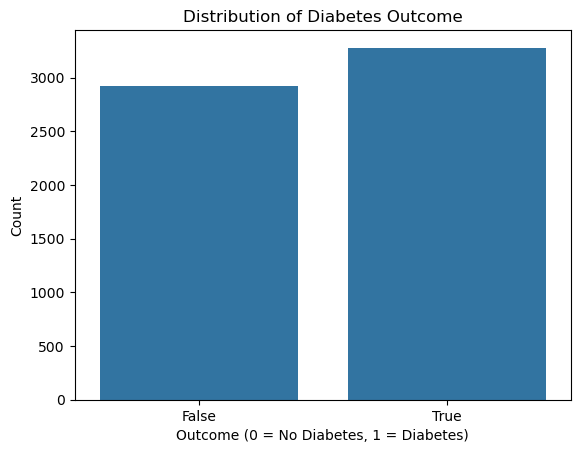

In [33]:
#visulaize the outcome data making sure we don't have biased data set
#This shows that we have almost double the data with no diabes in comparison to people with diabetes

sns.barplot(x=data['Tomorrow_Close_Positive'].value_counts().index,
            y=data['Tomorrow_Close_Positive'].value_counts().values)
plt.xlabel("Outcome (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Count")
plt.title("Distribution of Diabetes Outcome")
plt.show()

In [34]:
y = data['Tomorrow_Close_Positive']
X = data[['Open', 'High', 'Low', 'Close', 'Adj. Close',
       'Volume', 'week', 'First_day',
       'Last_day', 'SMA_7', 'V_SMA_7', 'SMA_14', 'V_SMA_14', 'EMA_7',
       'V_EMA_7', 'EMA_14', 'V_EMA_14']]

In [35]:
Highest_Accuracy = 0
Best_Seed = 0

# List of seeds to explore
seeds = [90, 95, 100, 242, 1500, 1001, 2023, 2000, 2003, 102, 2001, 2006]

# Features to normalize
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj. Close',
       'Volume', 'week', 'First_day',
       'Last_day', 'SMA_7', 'V_SMA_7', 'SMA_14', 'V_SMA_14', 'EMA_7',
       'V_EMA_7', 'EMA_14', 'V_EMA_14']

for seed in seeds:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize and fit the scaler on X_train only
    scaler = MinMaxScaler()
    scaler.fit(X_train[columns_to_scale])

    # Transform X_train and X_test using the fitted scaler
    X_train_scaled = X_train  # Avoid modifying the original DataFrame
    X_test_scaled = X_test

    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Train the Logistic Regression model
    LogisticRegressionmodel = RandomForestClassifier(random_state=seed)
    LogisticRegressionmodel.fit(X_train_scaled, y_train)

    # Make predictions on the correctly normalized X_test
    y_pred = LogisticRegressionmodel.predict(X_test_scaled)
    current_accuracy = accuracy_score(y_test, y_pred)

    # Store the best-performing model
    if current_accuracy > Highest_Accuracy:
        Best_Model = RandomForestClassifier(random_state=seed)
        Highest_Accuracy = current_accuracy
        Best_Seed = seed
        Best_y_pred = y_pred
        Best_y_test = y_test
        Best_x_test = X_test.copy()
        best_scaler = scaler

# Print the best model accuracy and classification report
print(f'Highest Accuracy was with seed {Best_Seed}\nAccuracy Rate = {Highest_Accuracy}')
print(classification_report(Best_y_test, Best_y_pred, target_names=['Tommorow is Negative', 'Tommorow is Positive']))



Highest Accuracy was with seed 102
Accuracy Rate = 0.5286521388216303
                      precision    recall  f1-score   support

Tommorow is Negative       0.50      0.49      0.49       584
Tommorow is Positive       0.55      0.56      0.56       655

            accuracy                           0.53      1239
           macro avg       0.53      0.53      0.53      1239
        weighted avg       0.53      0.53      0.53      1239



In [37]:
Highest_Accuracy2 = 0
Best_Seed2 = 0

# List of seeds to explore
seeds = [90, 95, 100, 242, 1500, 1001, 2023, 2000, 2003, 102, 2001, 2006]

# Features to normalize
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj. Close',
       'Volume', 'week', 'First_day',
       'Last_day', 'SMA_7', 'V_SMA_7', 'SMA_14', 'V_SMA_14', 'EMA_7',
       'V_EMA_7', 'EMA_14', 'V_EMA_14']

for seed in seeds:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize and fit the scaler on X_train only
    scaler = MinMaxScaler()
    scaler.fit(X_train[columns_to_scale])

    # Transform X_train and X_test using the fitted scaler
    X_train_scaled = X_train  # Avoid modifying the original DataFrame
    X_test_scaled = X_test

    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

    # Train the Logistic Regression model
    LogisticRegressionmodel = DecisionTreeClassifier(random_state=seed)
    LogisticRegressionmodel.fit(X_train_scaled, y_train)

    # Make predictions on the correctly normalized X_test
    y_pred = LogisticRegressionmodel.predict(X_test_scaled)
    current_accuracy = accuracy_score(y_test, y_pred)

    # Store the best-performing model
    if current_accuracy > Highest_Accuracy2:
        Best_Model2 = DecisionTreeClassifier()
        Highest_Accuracy2 = current_accuracy
        Best_Seed2 = seed
        Best_y_pred2 = y_pred
        Best_y_test2 = y_test
        Best_x_test2 = X_test.copy()
        best_scaler2 = scaler
      

# Print the best model accuracy and classification report
print(f'Highest Accuracy was with seed {Best_Seed2}\nAccuracy Rate = {Highest_Accuracy2}')
print(classification_report(Best_y_test2, Best_y_pred2, target_names=['Tommorow is Negative', 'Tommorow is Positive']))



Highest Accuracy was with seed 2001
Accuracy Rate = 0.5230024213075061
                      precision    recall  f1-score   support

Tommorow is Negative       0.49      0.50      0.50       585
Tommorow is Positive       0.55      0.54      0.55       654

            accuracy                           0.52      1239
           macro avg       0.52      0.52      0.52      1239
        weighted avg       0.52      0.52      0.52      1239



In [38]:
# Save the model and save the scaler
joblib.dump(Best_Model, 'RandomForestClassifier.pkl')
pickle.dump(best_scaler, open("scaler_RandomForest.pkl", "wb"))
joblib.dump(Best_Model2, 'DecisionTreeClassifier.pkl')
pickle.dump(best_scaler2, open("scaler_DecisionTree.pkl", "wb"))